# Geometric Positioning of InSAR Points

@author: Max Felius

## Hypothesis
The retrieval of sinkhole parameters can be improved by a better spreading of the measurement points.
- A better spreading of points will lead to a lower conditional number of the design matrix.
- A better spreading will lead to a higher fitting percentage and a lower RMSE.

## Predictions (better articulate this part...)
- Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Less points will provide a worse fit.
- Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- The further the points away from the center, the worse the fit will be.
- Very heterogenous points will provide a worse fit
- The more points with the same radius will give worse fit

## Design the experiment
- Define sinkhole using kinematic model
- Define inverse model to retrieve parameters
- Define tool to create point samples
- Generate seperate cases for each prediction and answer that prediction

## Notes
Conditional Number, $b=Ax$ <br>
"one should think of the condition number as being (very roughly) the rate at which the solution x will change with respect to a change in b"

What would be the best trade-off between the average model fit and the conditional number?

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import random
import os,sys,time
from tqdm import tqdm

In [3]:
#kinematic model 
#automatically introduce some noise into the system
def zg(R,r):
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2))
def zg_nois(R,r):
    noise_tune = 0.5
    return (1/(R*R))*np.exp(-np.pi*(r**2/R**2)) + (noise_tune*(1/(R*R))*np.random.uniform(0,1,size=len(r)))

In [4]:
# r = np.array([1,2,4,6,8,12,44,77,88,99,200,300,250,500,550])
# R = 550

# print(zg(R,r))

In [5]:
#defining the inverse model
def inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    return v, R, i, cond_number

In [6]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 95.78920335026163
R_wink2016_gaus = 553.0609564207195
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#coordinates
x0 = 25
y0 = 25

#Define the sinkhole grid
n = 100
x_range = R_wink2016_gaus
y_range = R_wink2016_gaus
x = np.linspace(x0-x_range/2,x0+x_range/2,n)
y = np.linspace(y0-y_range/2,y0+y_range/2,n)

#creat x/y grid
xv, yv = np.meshgrid(x,y)

#unravel the grids
x_unravel = xv.ravel()
y_unravel = yv.ravel()

In [7]:
'''
Example of how to create subsamples
'''
#example 1
def get_random_subsamples(n_sub,x_unravel,y_unravel):
# n_sub = 30
    idx = random.sample(range(0,len(x_unravel)),int(n_sub))
    
    #subsampling the arrays
    x_sub = x_unravel[idx]
    y_sub = y_unravel[idx]
    
    return x_sub, y_sub

In [8]:
def get_subsampled_arrays(x_sub,y_sub,r,delta_days):
    #create row arrays for x,y,z containing every epoch
    x_array = np.array([])
    y_array = np.array([])
    z_array = np.array([])
    t = np.array([])
    r_array = np.array([])

    nitems = 0
    for step in delta_days:
        n = len(x_sub)
        x_array = np.concatenate((x_array,x_sub))
        y_array = np.concatenate((y_array,y_sub))
        z_array = np.concatenate((z_array,step*v_wink2016_gaus*zg_nois(R_wink2016_gaus,r)))
        t = np.concatenate((t,[delta_days[nitems]]*n))
        r_array = np.concatenate((r_array,r))
        nitems += 1
    
    return x_array, y_array, z_array, t, r_array, nitems

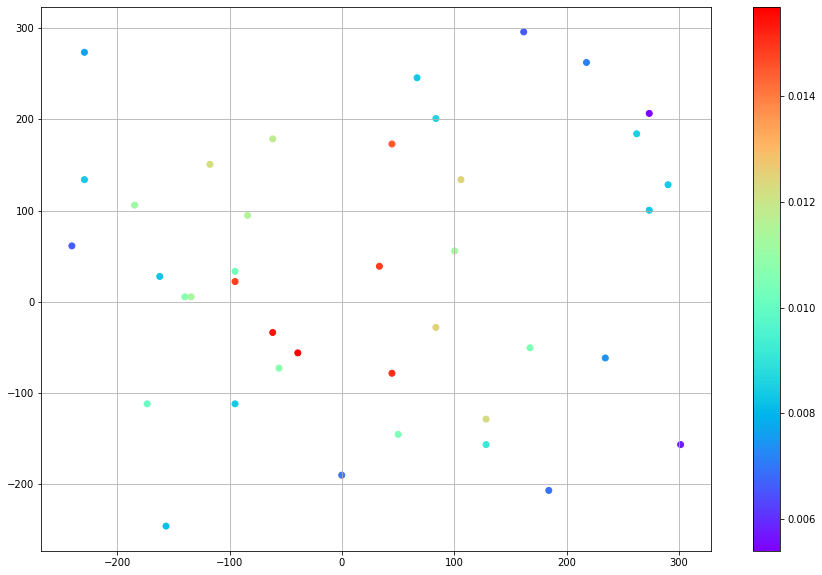

In [9]:
n_sub = 40

x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

#compute the radius
r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(15,10))
i = 3
h = axs.scatter(x_sub,y_sub,c=z_array[i*n_sub:n_sub+i*n_sub],cmap=plt.cm.rainbow)
plt.grid(True)
fig.colorbar(h);

In [10]:
number_subs = [x for x in range(1,100)]

#coordinates of center point to be evaluated
x0 = 25
y0 = 25

#Time vector is days
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#save variables
cond_saved = []
iter_saved = []

for n_sub in number_subs:
    x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

    #compute the radius
    r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

    x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

    #initial parameters
    R = 500
    v = 100
    
    #catch singular matrices
    try:
        v, R, i, cond_number = inverse_kinematic_model(v,t,R,r_array,z_array)
    except:
        cond_number = np.nan
        i = np.nan
    
    #save variables
    cond_saved.append(cond_number)
    iter_saved.append(i)

<ipython-input-5-e45dfbe1e672>:52: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-5-e45dfbe1e672>:52: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-5-e45dfbe1e672>:36: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)


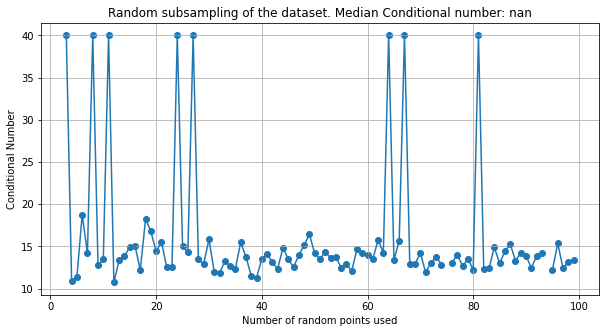

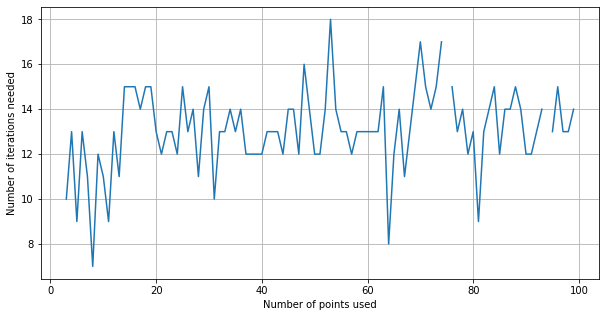

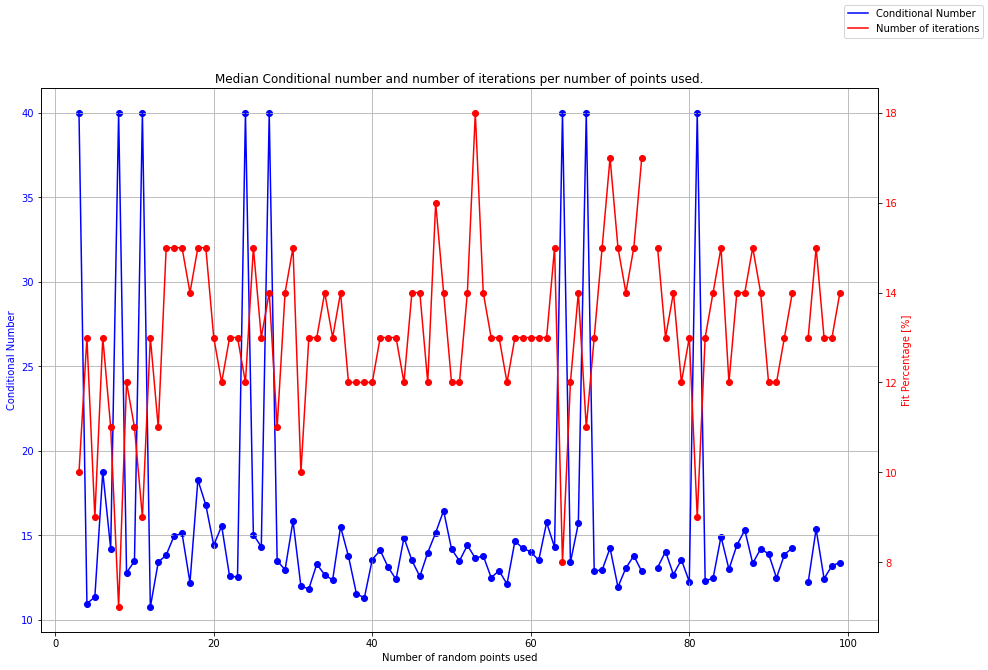

In [31]:

cond_saved = np.array(cond_saved)
cond_saved[cond_saved>40] = 40


plt.figure(figsize=(10,5))
plt.plot(number_subs,cond_saved)
plt.scatter(number_subs,cond_saved)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.median(cond_saved)

plt.title('Random subsampling of the dataset. Median Conditional number: {:.0f}'.format(mean))
plt.ylabel('Conditional Number')
plt.xlabel('Number of random points used')

plt.grid(True);

plt.figure(figsize=(10,5))
plt.plot(number_subs,iter_saved)

plt.ylabel('Number of iterations needed')
plt.xlabel('Number of points used')

plt.grid(True);

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(number_subs,cond_saved,c='b',label='Conditional Number')
ax1.scatter(number_subs,cond_saved,c='b')
ax1.set_title('Median Conditional number and number of iterations per number of points used.')
ax1.set_ylabel('Conditional Number',color='b')
ax1.set_xlabel('Number of random points used')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Fit Percentage [%]',color='r')
ax2.plot(number_subs,iter_saved,c='r',label='Number of iterations')
ax2.scatter(number_subs,iter_saved,c='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()
ax1.grid(True);

## Seperate Cases (Predictions)
- Case 1: Less points will provide a worse fit.
- Case 2: Higher fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).
- Case 3: Points on a line or spread out on a 2D plane won't affect the fit and conditional number.
- Case 4: The further the points away from the center, the worse the fit will be.
- Case 5: Very heterogenous points will provide a worse fit
- Case 6: The more points with the same radius will give worse fit

### Case 1

Less points will provide a worse fit. 


In [12]:
#defining the inverse model for case 1 and 2
def case_inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
    
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    ehat = yhat - y
    
    return ehat, y, cond_number

In [71]:
def simulate_sinkhole_parameter_retrieval(delta_days,x0,y0,max_subs,n_sims,x_unravel,y_unravel):
    '''
    '''
    number_subs = [x for x in range(1,max_subs)]
    
    #save variables
    ehat_saved = []
    y_saved = []
    fit_saved = []

    fit_total_save = np.zeros((n_sims,max_subs-1))
    cond_number_total_save = np.zeros((n_sims,max_subs-1))

    # for sim_num in range(n_sims):
    for sim_num in tqdm(range(n_sims),'Simulating'):
        for n_sub in number_subs:
            x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

            #compute the radius
            r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

            x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

            #initial parameters
            R = 500
            v = 100

            #catch singular matrices
            try:
                ehat, y, cond_number = case_inverse_kinematic_model(v,t,R,r_array,z_array)

                fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
            except:
                ehat = 0
                y = 0
                fit = 0
                cond_number = 1500

            #save variables
            ehat_saved.append(ehat)
            y_saved.append(y)
            fit_saved.append(fit)

            #filter out nan values
            if np.isnan(fit) or fit < 0:
                fit = 0
            if np.isnan(cond_number):
                cond_number = 1500

            fit_total_save[sim_num,n_sub-1] = fit
            cond_number_total_save[sim_num,n_sub-1] = cond_number
            
    return fit_total_save, cond_number_total_save, number_subs

In [13]:
max_subs = 100
number_subs = [x for x in range(1,max_subs)]

#coordinates of center point to be evaluated
x0 = 25
y0 = 25

#Time vector is days
delta_days = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])

#save variables
ehat_saved = []
y_saved = []
fit_saved = []

#number of times to run the simulation
n_sims = 200
fit_total_save = np.zeros((n_sims,max_subs-1))
cond_number_total_save = np.zeros((n_sims,max_subs-1))

# for sim_num in range(n_sims):
for sim_num in tqdm(range(n_sims),'Simulating'):
    for n_sub in number_subs:
        x_sub, y_sub = get_random_subsamples(n_sub,x_unravel,y_unravel)

        #compute the radius
        r = np.sqrt((x_sub-x0)**2 + (y_sub-y0)**2)

        x_array, y_array, z_array, t, r_array, nitems = get_subsampled_arrays(x_sub,y_sub,r,delta_days)

        #initial parameters
        R = 500
        v = 100

        #catch singular matrices
        try:
            ehat, y, cond_number = case_inverse_kinematic_model(v,t,R,r_array,z_array)

            fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
        except:
            ehat = 0
            y = 0
            fit = 0

        #save variables
        ehat_saved.append(ehat)
        y_saved.append(y)
        fit_saved.append(fit)
        
        #filter out nan values
        if np.isnan(fit) or fit < 0:
            fit = 0
        if np.isnan(cond_number):
            cond_number = 1e16
            
        fit_total_save[sim_num,n_sub-1] = fit
        cond_number_total_save[sim_num,n_sub-1] = cond_number

Simulating:   0%|          | 1/200 [00:09<31:07,  9.38s/it]<ipython-input-12-bde32d421b83>:52: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-12-bde32d421b83>:52: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
Simulating:   2%|▏         | 3/200 [00:27<30:10,  9.19s/it]<ipython-input-12-bde32d421b83>:36: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:   2%|▏         | 4/200 [00:36<29:39,  9.08s/it]<ipython-input-12-bde32d421b83>:43: RuntimeWarning: invalid value encountered in matmul
  dx = Qxhat @ J.T @ invQyy @ dy
Simulating: 100%|██████████| 200/200 [32:18<00:00,  9.69s/it]


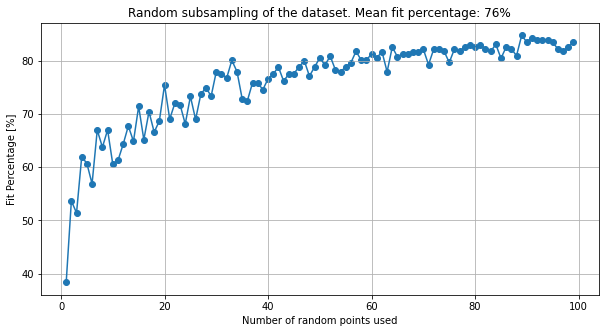

In [14]:
#extracting average fit percentages    
avg_data = np.sum(fit_total_save,axis=0)/n_sims

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(number_subs,avg_data)
plt.scatter(number_subs,avg_data)

#mean of the conditional number. SKIPPED THE FIRST ENTRY
mean = np.mean(avg_data)

plt.title('Random subsampling of the dataset. Mean fit percentage: {:.0f}%'.format(mean))
plt.ylabel('Fit Percentage [%]')
plt.xlabel('Number of random points used')

plt.grid(True);

#### Conclusions
- Less number of points will provide a worse fit. The increase in points provides an increase in Fit Percentage.

### Case 2
Higher model fit will be accompanied with a lower conditional number (well-conditioned vs ill-conditioned).

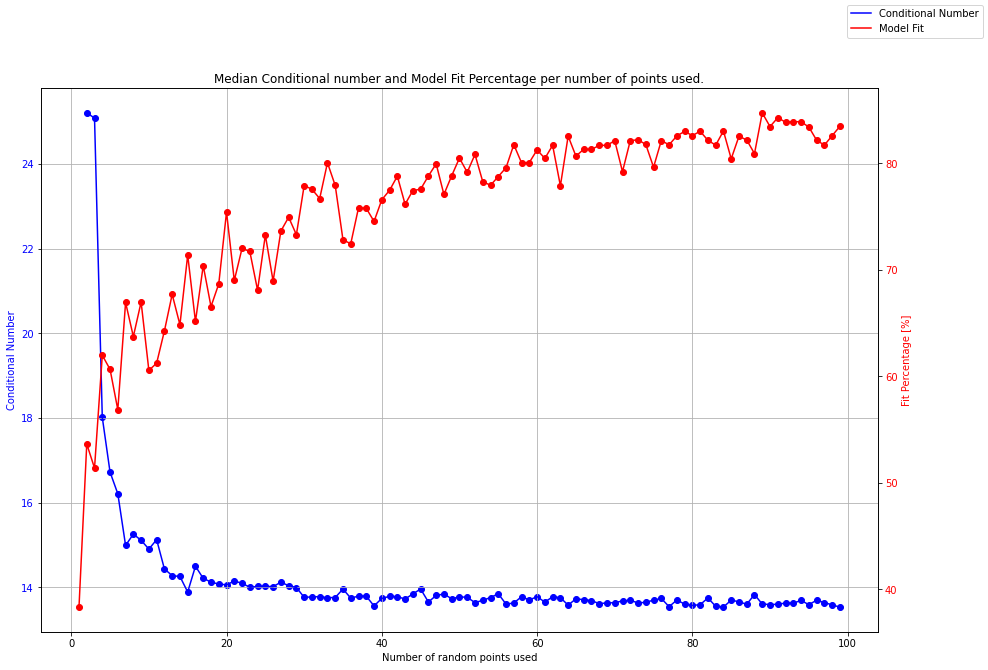

In [15]:
avg_cond = np.median(cond_number_total_save,axis=0)

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.plot(number_subs[1:],avg_cond[1:],c='b',label='Conditional Number')
ax1.scatter(number_subs[1:],avg_cond[1:],c='b')
ax1.set_title('Median Conditional number and Model Fit Percentage per number of points used.')
ax1.set_ylabel('Conditional Number',color='b')
ax1.set_xlabel('Number of random points used')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Fit Percentage [%]',color='r')
ax2.plot(number_subs,avg_data,c='r',label='Model Fit')
ax2.scatter(number_subs,avg_data,c='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend()
ax1.grid(True);

#### Conclusion
- The higher the model fit percentage the lower the conditional number.
- The conditional number will converge to a specific value and not to zero.

### Case 3

Points on a line or spread out on a 2D plane won't affect the fit and conditional number.

Plot fit vs number of radia used?

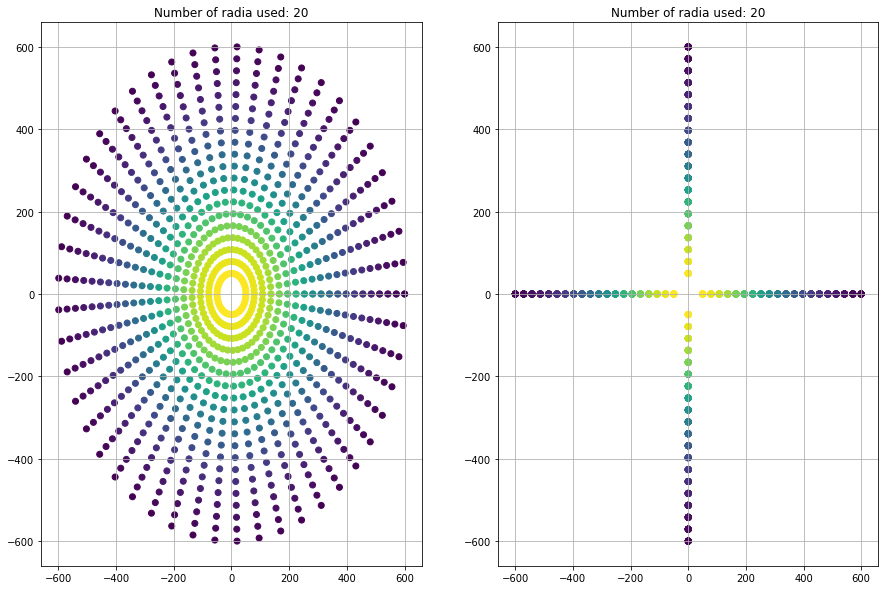

In [73]:
# Point on a circle with the same r
R_circ = 600
n_circ = 50
theta = np.deg2rad(np.linspace(0,360,n_circ))
num_r = 20
r_array_circ = np.linspace(50,R_circ,num_r)

#total number of points is nxn

x_circ = np.array([])
y_circ = np.array([])
z_circ = np.array([])

for item in r_array_circ:
    x_item = item*np.cos(theta)
    y_item = item*np.sin(theta)
    x_circ = np.concatenate((x_circ,x_item))
    y_circ = np.concatenate((y_circ,y_item))
    r = np.sqrt((x_item**2)+(y_item**2))
    z_circ = np.concatenate((z_circ,zg(R_circ,r)))

x_line = np.array([])
y_line = np.array([])
z_line = np.array([])

phi = np.deg2rad(np.arange(0,90*n_circ,90))

for item in r_array_circ:
    x_item = item*np.cos(phi)
    y_item = item*np.sin(phi)
    x_line = np.concatenate((x_line,x_item))
    y_line = np.concatenate((y_line,y_item))
    r = np.sqrt((x_item**2)+(y_item**2))
    z_line = np.concatenate((z_line,zg(R_circ,r)))    
    
#plot the figure
fig, ax = plt.subplots(ncols=2,figsize=(15,10))
h = ax[0].scatter(x_circ,y_circ,c=z_circ)

ax[0].set_title(f'Number of radia used: {num_r}')

# fig.colorbar(h,axis=ax[0])
ax[0].grid(True);

h2= ax[1].scatter(x_line,y_line,c=z_line)
ax[1].set_title(f'Number of radia used: {num_r}')
ax[1].grid(True);

In [74]:
max_subs = 40
n_sims_circ = 100

assert max_subs < n_circ, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims_circ
f = x_circ #x_unravel
g = y_circ #y_unravel

#the sinkhole is predefined
fit_total_save_circ, cond_number_total_save_circ, number_subs_circ = simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g)

Simulating:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-12-bde32d421b83>:52: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-12-bde32d421b83>:52: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
Simulating:   1%|          | 1/100 [00:00<01:08,  1.44it/s]<ipython-input-12-bde32d421b83>:36: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:   8%|▊         | 8/100 [00:14<02:40,  1.74s/it]<ipython-input-12-bde32d421b83>:43: RuntimeWarning: invalid value encountered in matmul
  dx = Qxhat @ J.T @ invQyy @ dy
Simulating: 100%|██████████| 100/100 [06:57<00:00,  4.17s/it]


In [75]:
max_subs = 40
n_sims_circ = 100

assert max_subs < n_circ, 'Not enough initial points to subsample.'

a = delta_days
b = x0
c = y0
d = max_subs
e = n_sims_circ
f = x_line #x_unravel
g = y_line #y_unravel

#the sinkhole is predefined
fit_total_save_line, cond_number_total_save_line, number_subs_line = simulate_sinkhole_parameter_retrieval(a,b,c,d,e,f,g)

Simulating:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-12-bde32d421b83>:52: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-12-bde32d421b83>:52: RuntimeWarning: invalid value encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
Simulating:   3%|▎         | 3/100 [00:04<01:49,  1.13s/it]<ipython-input-12-bde32d421b83>:36: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
Simulating:   5%|▌         | 5/100 [00:05<01:17,  1.22it/s]<ipython-input-12-bde32d421b83>:43: RuntimeWarning: invalid value encountered in matmul
  dx = Qxhat @ J.T @ invQyy @ dy
Simulating: 100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


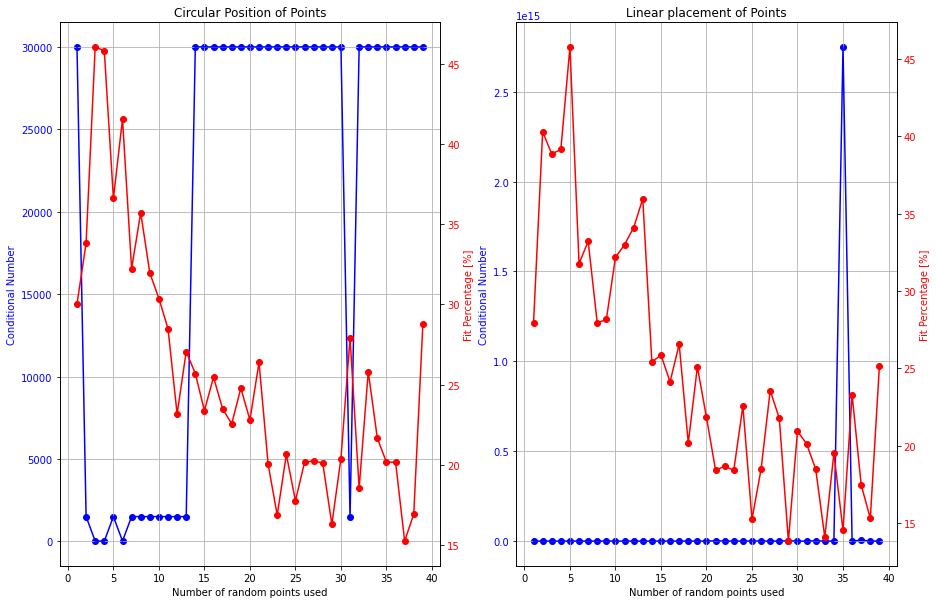

In [81]:
avg_cond_circ = np.median(cond_number_total_save_circ,axis=0)
avg_data_circ = np.sum(fit_total_save_circ,axis=0)/n_sims_circ

ccc = 30000
avg_cond_circ[avg_cond_circ>ccc] = ccc

fig, (ax1,ax3) = plt.subplots(1,2,figsize=(15,10))

ax1.plot(number_subs_circ,avg_cond_circ,c='b',label='Conditional Number')
ax1.scatter(number_subs_circ,avg_cond_circ,c='b')
# ax1.set_title('Median Conditional number and Model Fit Percentage per number of points used.')
ax1.set_title('Circular Position of Points')
ax1.set_ylabel('Conditional Number',color='b')
ax1.set_xlabel('Number of random points used')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('Fit Percentage [%]',color='r')
ax2.plot(number_subs_circ,avg_data_circ,c='r',label='Model Fit')
ax2.scatter(number_subs_circ,avg_data_circ,c='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.grid(True)

# fig.legend()3.grid(True);

#line figures

avg_cond_line = np.median(cond_number_total_save_line,axis=0)
avg_data_line = np.sum(fit_total_save_line,axis=0)/n_sims_circ
# avg_cond_line[avg_cond_line>700] = 700

ax3.plot(number_subs_line,avg_cond_line,c='b',label='Conditional Number')
ax3.scatter(number_subs_line,avg_cond_line,c='b')
# ax3.set_title('Median Conditional number and Model Fit Percentage per number of points used.')
ax3.set_title('Linear placement of Points')
ax3.set_ylabel('Conditional Number',color='b')
ax3.set_xlabel('Number of random points used')
ax3.tick_params(axis='y', labelcolor='b')

ax4 = ax3.twinx()

ax4.set_ylabel('Fit Percentage [%]',color='r')
ax4.plot(number_subs_line,avg_data_line,c='r',label='Model Fit')
ax4.scatter(number_subs_line,avg_data_line,c='r')
ax4.tick_params(axis='y', labelcolor='r')

# fig.legend()
ax3.grid(True);

#### Conclusion
- Points on a circle with similar radius have a better solution than point on straight lines with similar radius.

### Case 4

The further the points away from the center, the worse the fit will be.

### Case 5

Very heterogenous points will provide a worse fit.

### Case 6

The more points with the same radius will give worse fit.

### Discussion
- Will the conditional number change with the point geometry?
- What is the effect of the amount of noise on the measurement points and the fit?
- How to relate the implemented noise with the speed of the increasing fit percentage?